<a href="https://colab.research.google.com/github/breakwa/xxxformer/blob/main/xxxformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install reformer_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-py3-none-any.whl size=2901 sha256=90df31ff30acda0cc93d8a8ace708f7b5a8ba238dd4f4e4e4b5fd5e94c45db7e
  Stored in directory: /root/.cache/pip/wheels/4a/2c/c3/9a1cb267c0d0d9b6eeba7952addb32b17857d1f799690c27a8
  Created wheel for product-key-memory: filename=product_key_memory-0.1.10-py3-none-any.whl size=3072 sha256=a5f6b98110f79b734ad923b6bd9a29b2dc4b10226a98bf1841b94b484ea1fcb0
  Stored in directory: /root/.cache/pip/wheels/43/78/51/06648579a50c8e83f24ebfbdfd66462d1b88315a3491deba86
Successfully built axial-positional-embedding product-key-memory


In [ ]:
import reformer_pytorch
import pandas
import sklearn
import torchvision
import numpy
import matplotlib

In [ ]:
import torch
print(torch.cuda.is_available())		 # 查看GPu设备是否可用
print(torch.cuda.device_count()) 		# 查看GPu设备数量
print(torch.cuda.get_device_name())   	# 查看当前GPu设备名称，默认设备id从0开始
print(torch.cuda.current_device())		# 查看当前GPu设备id


True
1
Tesla T4
0


# 3.utils

## 3.1 download data

In [ ]:
import requests

if __name__=="__main__":
    source_url = 'https://cloud.tsinghua.edu.cn/d/e1ccfff39ad541908bae/files/?p=%2Fall_six_datasets.zip&dl=1'
    headers = {'User-Agent': 'Mozilla/5.0'}
    res = requests.get(source_url, headers=headers)

    with open('/content/drive/MyDrive/DATA_reformer/datasets.zip', 'wb') as f:
        f.write(res.content)


## 3.2 mask

In [ ]:
import torch


class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask


## 3.3 metrics

In [ ]:
import numpy as np


def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)  #.sum(0) axis=0       .mean(0) axis=0 
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    return (u / d).mean(-1)


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)

    return mae, mse, rmse, mape, mspe


## 3.4 time features

In [ ]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset


class TimeFeature:   #将dataframe转换为ndarry
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5         # 0-1    --->     (-0.5,0.5)


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])


## 3.5 tools

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

plt.switch_backend('agg')


def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


class StandardScaler():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean


def visual(true, preds=None, name='./pic/test.pdf'):
    """
    Results visualization
    """
    plt.figure()
    plt.plot(true, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(preds, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')


# 1.layers

## 1.1AutoCorrelation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from math import sqrt
import os


class AutoCorrelation(nn.Module):
    """
    AutoCorrelation Mechanism with the following two phases:
    (1) period-based dependencies discovery
    (2) time delay aggregation
    This block can replace the self-attention family mechanism seamlessly.
    """
    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def time_delay_agg_training(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the training phase.
        """
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the inference phase.
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        weights, delay = torch.topk(mean_value, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_full(self, values, corr):
        """
        Standard version of Autocorrelation
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        weights, delay = torch.topk(corr, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[..., i].unsqueeze(-1)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * (tmp_corr[..., i].unsqueeze(-1))
        return delays_agg

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]

        # period-based dependencies
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)

        # time delay agg
        if self.training:
            V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        else:
            V = self.time_delay_agg_inference(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)


class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AutoCorrelationLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_correlation = correlation
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_correlation(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn


## 1.2Autoformer encoder decoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class my_Layernorm(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """
    def __init__(self, channels):
        super(my_Layernorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels)

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias


class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class EncoderLayer(nn.Module):
    """
    Autoformer encoder layer with the progressive decomposition architecture
    """
    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn


class Encoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    """
    Autoformer decoder layer with the progressive decomposition architecture
    """
    def __init__(self, self_attention, cross_attention, d_model, c_out, d_ff=None,
                 moving_avg=25, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False)
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.decomp3 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=3, stride=1, padding=1,
                                    padding_mode='circular', bias=False)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend


class Decoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, trend=None):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)
            trend = trend + residual_trend

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x, trend


## 1.3Embedding

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import math


class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        # u = torch.tensor(300.) # 100<u<500                                 # **************************
        # self.u_law_function = lambda w: (torch.log(torch.tensor(1.)+torch.abs(w)*u ))/(torch.log(torch.tensor(1.)+u))    #***************************
    def forward(self, x):
        # x = self.u_law_function(x)                              #***************************
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()

        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6, 'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)


class DataEmbedding_wo_pos(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_wo_pos, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)


## 1.4SelfAttention_Family

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np
import math
from math import sqrt
# from utils.masking import TriangularCausalMask, ProbMask
from reformer_pytorch import LSHSelfAttention
import os


class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)   #按照爱因斯坦求和约定，当一个单独项目内有标号变量出现两次，一次是上标，一次是下标时，则必须总和所有这单独项目的可能值。

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)


class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top):  # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k))  # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze()

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   M_top, :]  # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1))  # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else:  # use mask
            assert (L_Q == L_V)  # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1)  # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
        torch.arange(H)[None, :, None],
        index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V]) / L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2, 1)
        keys = keys.transpose(2, 1)
        values = values.transpose(2, 1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item()  # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item()  # c*ln(L_q)

        U_part = U_part if U_part < L_K else L_K
        u = u if u < L_Q else L_Q

        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)

        # add scale factor
        scale = self.scale or 1. / sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)

        return context.contiguous(), attn


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn


class ReformerLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None, causal=False, bucket_size=4, n_hashes=4):
        super().__init__()
        self.bucket_size = bucket_size
        self.attn = LSHSelfAttention(
            dim=d_model,
            heads=n_heads,
            bucket_size=bucket_size,
            n_hashes=n_hashes,
            causal=causal
        )

    def fit_length(self, queries):
        # inside reformer: assert N % (bucket_size * 2) == 0
        B, N, C = queries.shape
        if N % (self.bucket_size * 2) == 0:
            return queries
        else:
            # fill the time series
            fill_len = (self.bucket_size * 2) - (N % (self.bucket_size * 2))
            return torch.cat([queries, torch.zeros([B, fill_len, C]).to(queries.device)], dim=1)

    def forward(self, queries, keys, values, attn_mask):
        # in Reformer: defalut queries=keys
        B, N, C = queries.shape
        queries = self.attn(self.fit_length(queries))[:, :N, :]
        return queries, None


## 1.5Transformer_EncDec

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=2,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1, 2)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x


# 4.data provider

## 4.1 data_loader

In [ ]:
import os
import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
# from utils.timefeatures import time_features
import warnings

warnings.filterwarnings('ignore')


class Dataset_ETT_hour(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_ETT_minute(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTm1.csv',
                 target='OT', scale=True, timeenc=0, freq='t'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        print(df_raw)
        border1s = [0, 12 * 30 * 24 * 4 - self.seq_len, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - self.seq_len]
        border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Custom(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        cols = list(df_raw.columns)
        cols.remove(self.target)
        cols.remove('date')
        df_raw = df_raw[['date'] + cols + [self.target]]
        # print(cols)
        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)
    

class Dataset_Pred(Dataset):
    def __init__(self, root_path, flag='pred', size=None,
                 features='S', data_path='ETTh1.csv',
                 target='OT', scale=True, inverse=False, timeenc=0, freq='15min', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['pred']

        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''
        if self.cols:
            cols = self.cols.copy()
            cols.remove(self.target)
        else:
            cols = list(df_raw.columns)
            cols.remove(self.target)
            cols.remove('date')
        df_raw = df_raw[['date'] + cols + [self.target]]
        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len + 1, freq=self.freq)

        df_stamp = pd.DataFrame(columns=['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = self.data_x[r_begin:r_begin + self.label_len]
        else:
            seq_y = self.data_y[r_begin:r_begin + self.label_len]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


## 4.2data_factory

In [ ]:
# from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Pred
from torch.utils.data import DataLoader

data_dict = {
    'ETTh1': Dataset_ETT_hour,
    'ETTh2': Dataset_ETT_hour,
    'ETTm1': Dataset_ETT_minute,
    'ETTm2': Dataset_ETT_minute,
    'custom': Dataset_Custom,
}


def data_provider(args, flag):
    Data = data_dict[args.data]
    timeenc = 0 if args.embed != 'timeF' else 1
    print(Data)
    print(timeenc)
    if flag == 'test':
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq
    elif flag == 'pred':
        shuffle_flag = False
        drop_last = False
        batch_size = 1
        freq = args.freq
        Data = Dataset_Pred
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq
    )
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader


In [ ]:
data_set = Dataset_ETT_hour(
        root_path='/content/drive/MyDrive/DATA_reformer/datasets/all_six_datasets/ETT-small/',
        data_path='REFINED_NBC news G16B3-QP28.csv',
        flag='test',
        size=[98, 48, 24],
        features='M',
        target='OT',
        timeenc=1,
        # freq='d'
    )



In [ ]:
# i = 0
# for item in data_set:
#   if i < 1:
#     i = i + 1
#     print(item)

In [ ]:
# data_provider.timeenc

In [ ]:
# args.data
# args.freq
# args.target,
# args.features

In [ ]:
# args.root_path,

In [ ]:
# '''data_set'''
# i = 0
# print("data_set:", data_set)
# for item in data_loader:
#   i = i+1
#   if i < 5:
#     print("item:", item)
#     print("item size:", len(item))

# 6.model

## 6.0.transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from layers.Embed import DataEmbedding, DataEmbedding_wo_pos
# from layers.AutoCorrelation import AutoCorrelation, AutoCorrelationLayer
# from layers.Autoformer_EncDec import Encoder, Decoder, EncoderLayer, DecoderLayer, my_Layernorm, series_decomp
import math
import numpy as np


class Model_transformer(nn.Module):
    """
    Autoformer is the first method to achieve the series-wise connection,
    with inherent O(LlogL) complexity
    """
    def __init__(self, configs):
        super(Model_transformer, self).__init__()
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention

        # Decomp
        kernel_size = configs.moving_avg
        self.decomp = series_decomp(kernel_size)

        # Embedding
        # The series-wise connection inherently contains the sequential information.
        # Thus, we can discard the position embedding of transformers.
        self.enc_embedding = DataEmbedding_wo_pos(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                                  configs.dropout)
        self.dec_embedding = DataEmbedding_wo_pos(configs.dec_in, configs.d_model, configs.embed, configs.freq,
                                                  configs.dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(False, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=configs.output_attention),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    moving_avg=configs.moving_avg,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=my_Layernorm(configs.d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(True, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=False),
                        configs.d_model, configs.n_heads),
                    AutoCorrelationLayer(
                        AutoCorrelation(False, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.c_out,
                    configs.d_ff,
                    moving_avg=configs.moving_avg,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.d_layers)
            ],
            norm_layer=my_Layernorm(configs.d_model),
            projection=nn.Linear(configs.d_model, configs.c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        # decomp init
        mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
        zeros = torch.zeros([x_dec.shape[0], self.pred_len, x_dec.shape[2]], device=x_enc.device)
        seasonal_init, trend_init = self.decomp(x_enc)
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.label_len:, :], zeros], dim=1)
        # enc
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)
        # dec
        dec_out = self.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask,
                                                 trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part

        if self.output_attention:
            return dec_out[:, -self.pred_len:, :], attns
        else:
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]


## 6.1.autoformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from layers.Transformer_EncDec import Decoder, DecoderLayer, Encoder, EncoderLayer, ConvLayer
# from layers.SelfAttention_Family import FullAttention, AttentionLayer
# from layers.Embed import DataEmbedding
import numpy as np


class Model_autoformer(nn.Module):
    """
    Vanilla Transformer with O(L^2) complexity
    """
    def __init__(self, configs):
        super(Model_autoformer, self).__init__()
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention

        # Embedding
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                           configs.dropout)
        self.dec_embedding = DataEmbedding(configs.dec_in, configs.d_model, configs.embed, configs.freq,
                                           configs.dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=configs.output_attention), configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        FullAttention(True, configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads),
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model),
            projection=nn.Linear(configs.d_model, configs.c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):

        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)

        if self.output_attention:
            return dec_out[:, -self.pred_len:, :], attns
        else:
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]


## 6.2 informer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from utils.masking import TriangularCausalMask, ProbMask
# from layers.Transformer_EncDec import Decoder, DecoderLayer, Encoder, EncoderLayer, ConvLayer
# from layers.SelfAttention_Family import FullAttention, ProbAttention, AttentionLayer
# from layers.Embed import DataEmbedding
import numpy as np


class Model_informer(nn.Module):
    """
    Informer with Propspare attention in O(LlogL) complexity
    """
    def __init__(self, configs):
        super(Model_informer, self).__init__()
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention

        # Embedding
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                           configs.dropout)
        self.dec_embedding = DataEmbedding(configs.dec_in, configs.d_model, configs.embed, configs.freq,
                                           configs.dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        ProbAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=configs.output_attention),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            [
                ConvLayer(
                    configs.d_model
                ) for l in range(configs.e_layers - 1)
            ] if configs.distil else None,
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        ProbAttention(True, configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads),
                    AttentionLayer(
                        ProbAttention(False, configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model),
            projection=nn.Linear(configs.d_model, configs.c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):

        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)

        if self.output_attention:
            return dec_out[:, -self.pred_len:, :], attns
        else:
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]


## 6.3 reformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from layers.Transformer_EncDec import Decoder, DecoderLayer, Encoder, EncoderLayer, ConvLayer
# from layers.SelfAttention_Family import ReformerLayer
# from layers.Embed import DataEmbedding
import numpy as np


class Model_reformer(nn.Module):
    """
    Reformer with O(LlogL) complexity
    - It is notable that Reformer is not proposed for time series forecasting, in that it cannot accomplish the cross attention.
    - Here is only one adaption in BERT-style, other possible implementations can also be acceptable.
    - The hyper-parameters, such as bucket_size and n_hashes, need to be further tuned.
    The official repo of Reformer (https://github.com/lucidrains/reformer-pytorch) can be very helpful, if you have any questiones.
    """

    def __init__(self, configs):
        super(Model_reformer, self).__init__()
        self.pred_len = configs.pred_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention

        # Embedding
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                           configs.dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    ReformerLayer(None, configs.d_model, configs.n_heads, bucket_size=configs.bucket_size,
                                  n_hashes=configs.n_hashes),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        self.projection = nn.Linear(configs.d_model, configs.c_out, bias=True)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        # add placeholder
        x_enc = torch.cat([x_enc, x_dec[:, -self.pred_len:, :]], dim=1)
        x_mark_enc = torch.cat([x_mark_enc, x_mark_dec[:, -self.pred_len:, :]], dim=1)
        # Reformer: encoder only
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)
        enc_out = self.projection(enc_out)

        if self.output_attention:
            return enc_out[:, -self.pred_len:, :], attns
        else:
            return enc_out[:, -self.pred_len:, :]  # [B, L, D]


# 2.exp

## 2.1 exp_basic

In [ ]:
import os
import torch
import numpy as np


class Exp_Basic(object):
    def __init__(self, args):
        self.args = args
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        raise NotImplementedError
        return None

    def _acquire_device(self):
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(
                self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _get_data(self):
        pass

    def vali(self):
        pass

    def train(self):
        pass

    def test(self):
        pass


## 2.2 exp_main

In [ ]:
# from data_provider.data_factory import data_provider
# from exp.exp_basic import Exp_Basic
# from models import Informer, Autoformer, Transformer, Reformer
# from utils.tools import EarlyStopping, adjust_learning_rate, visual
# from utils.metrics import metric

import numpy as np
import torch
import torch.nn as nn
from torch import optim

import os
import time

import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')


class Exp_Main(Exp_Basic):
    def __init__(self, args):
        super(Exp_Main, self).__init__(args)

    def _build_model(self):
        model_dict = {
            'Autoformer': Model_autoformer,
            'Transformer': Model_transformer,
            'Informer': Model_informer,
            'Reformer': Model_reformer,
        }
        # model_dict = {
        #     'Autoformer': Autoformer,
        #     'Transformer': Transformer,
        #     'Informer': Informer,
        #     'Reformer': Reformer,
        # }
        # model = model_dict[self.args.model].Model(self.args).float()
        model = model_dict[self.args.model](self.args).float()


        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

                pred = outputs.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred, true)

                total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')
        test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                batch_x = batch_x.float().to(self.device)

                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                        f_dim = -1 if self.args.features == 'MS' else 0
                        outputs = outputs[:, -self.args.pred_len:, f_dim:]
                        batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                        loss = criterion(outputs, batch_y)
                        train_loss.append(loss.item())
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark, batch_y)

                    f_dim = -1 if self.args.features == 'MS' else 0
                    outputs = outputs[:, -self.args.pred_len:, f_dim:]
                    batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch + 1, self.args)

        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))

        return self.model

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='test')
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds = []
        trues = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if self.args.features == 'MS' else 0
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()

                pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
                true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

                preds.append(pred)
                trues.append(true)
                if i % 20 == 0:
                    input = batch_x.detach().cpu().numpy()
                    gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                    pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                    visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))

        preds = np.array(preds)
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))
        f = open("result.txt", 'a')
        f.write(setting + "  \n")
        f.write('mse:{}, mae:{}'.format(mse, mae))
        f.write('\n')
        f.write('\n')
        f.close()

        np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path + 'pred.npy', preds)
        np.save(folder_path + 'true.npy', trues)

        return

    def predict(self, setting, load=False):
        pred_data, pred_loader = self._get_data(flag='pred')

        if load:
            path = os.path.join(self.args.checkpoints, setting)
            best_model_path = path + '/' + 'checkpoint.pth'
            self.model.load_state_dict(torch.load(best_model_path))

        preds = []

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros([batch_y.shape[0], self.args.pred_len, batch_y.shape[2]]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)
                # encoder - decoder
                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        if self.args.output_attention:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                        else:
                            outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                else:
                    if self.args.output_attention:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                pred = outputs.detach().cpu().numpy()  # .squeeze()
                preds.append(pred)

        preds = np.array(preds)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        np.save(folder_path + 'real_prediction.npy', preds)

        return preds

# predict

In [ ]:
import torch
print(torch.cuda.is_available())		 # 查看GPu设备是否可用
print(torch.cuda.device_count()) 		# 查看GPu设备数量
print(torch.cuda.get_device_name())   	# 查看当前GPu设备名称，默认设备id从0开始
print(torch.cuda.current_device())		# 查看当前GPu设备id


True
1
Tesla T4
0


In [ ]:
torch.cuda.is_available() 
import torch
torch.cuda.set_device(0)

In [ ]:
import argparse
import os
import torch
# from exp.exp_main import Exp_Main#exp stands for experiments
import random
import numpy as np
# from utils.tools import dotdict

fix_seed = 2021 
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')#模型id
parser.add_argument('--model', type=str, required=True, default='Autoformer',#选择模型
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')#数据类型
parser.add_argument('--root_path', type=str, default='/content/drive/MyDrive/DATA_reformer/datasets/all_six_datasets/ETT-small/', help='root path of the data file')#数据文件夹路径
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')#具体文件
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')#不太懂 OT好像代表Output Target,要预测的单变量
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='/content/drive/MyDrive/DATA_reformer/checkpoints/', help='location of model checkpoints')#保存模型

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')#输入序列长度
parser.add_argument('--label_len', type=int, default=48, help='start token length')#这个label_len未完全搞懂
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')#输出序列长度

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')#输出长度
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads 
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')#窗口滑动平均数
parser.add_argument('--factor', type=int, default=1, help='attn factor')#attn factor不太理解
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)#是否在encoder里面使用知识蒸馏
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding不太能get到
parser.add_argument('--activation', type=str, default='gelu', help='activation')#激活函数default=gelu
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')#encoder的output_attention是否输出
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')#是否预测未见的未来数据,也就是是否进行推理的意思

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# num_workers是加载数据(batch)的线程数目
parser.add_argument('--itr', type=int, default=2, help='experiments times')#实验次数
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience: 当early stop被激活(如发现loss相比上一个epoch训练没有下降)，则经过patience个epoch后停止训练
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#使用自动混合精度训练

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'OT'
args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #是否使用多卡的判断
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'h'
args.checkpoints = '/content/drive/MyDrive/DATA_reformer/checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = '/content/drive/MyDrive/DATA_reformer/datasets/all_six_datasets/ETT-small/'
args.data_path ='REFINED_NBC news G16B3-QP28.csv' 
args.model_id='ETTh1_96_24'
args.model = 'Autoformer'
args.data = 'ETTh1'
args.features = 'M'
args.seq_len = 96
args.label_len = 48
args.pred_len = 24
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 1
args.enc_in = 7
args.dec_in =7
args.c_out = 7
args.d_model = 512

args.des = 'Exp'
args.itr = 1      #1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.output_attention = False
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 32 
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10    #10
print('Args in experiment:')
print(args)

# Exp = Exp_Main



Args in experiment:
{'target': 'OT', 'des': 'Exp', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': '/content/drive/MyDrive/DATA_reformer/checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': '/content/drive/MyDrive/DATA_reformer/datasets/all_six_datasets/ETT-small/', 'data_path': 'REFINED_NBC news G16B3-QP28.csv', 'model_id': 'ETTh1_96_24', 'model': 'Autoformer', 'data': 'ETTh1', 'features': 'M', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 1, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'd_model': 512, 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 3, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

for ii in range(args.itr):#itr就是实验次数可不是epoch，parser.add_argument('--itr', type=int, default=2, help='experiments times')
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    exp = Exp_Main(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)#setting是用来保存模型的名字用的，很细节
    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()
    print(3)



Use GPU: cuda:0
1
>>>>>>>start training : ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
<class '__main__.Dataset_ETT_hour'>
1
train 8521
<class '__main__.Dataset_ETT_hour'>
1
val 2857
<class '__main__.Dataset_ETT_hour'>
1
test 2857
	iters: 100, epoch: 1 | loss: 1.1393069
	speed: 0.1437s/iter; left time: 368.0148s
	iters: 200, epoch: 1 | loss: 0.8747768
	speed: 0.0694s/iter; left time: 170.8397s
Epoch: 1 cost time: 26.029104709625244
Epoch: 1, Steps: 266 | Train Loss: 0.9020743 Vali Loss: 1.5408937 Test Loss: 1.7541547
Validation loss decreased (inf --> 1.540894).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.5427865
	speed: 0.2051s/iter; left time: 470.7698s
	iters: 200, epoch: 2 | loss: 0.5512825
	speed: 0.0710s/iter; left time: 155.8516s
Epoch: 2 cost time: 19.415918111801147
Epoch: 2, Steps: 266 | Train Loss: 0.6356441 Vali Loss: 1.4129847 Test Loss: 1.5737388
Validatio

# plot

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example #模仿informer 的 colab example的custom_dataset与predict部分
import pandas as pd
args.root_path = '/content/drive/MyDrive/DATA_reformer/datasets/all_six_datasets/ETT-small/'
args.data_path = 'ETTh2.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [ ]:
args.do_predict = True
if args.do_predict:
    print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    prediction=exp.predict(setting, True)#data_factory做好了pred里面的batch_size=1的情况，是autoformer在informer基础之上做的
    torch.cuda.empty_cache()
    print('>>>end>>>>')

>>>>>>>predicting : ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
<class '__main__.Dataset_ETT_hour'>
1
pred 1
>>>end>>>>


In [ ]:
setting

'ETTh1_96_24_Autoformer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0'

In [ ]:
print(prediction)

[[[ 0.55201644 -0.14547308 -0.14696065  0.72414106  0.979641
    1.2544575  -0.16230269]
  [ 1.6824205   0.00898075 -0.23358944  0.5187563   1.0084326
    1.3392131  -0.13548324]
  [ 1.9432167   0.00673942 -0.21658507  0.49259612  0.9980917
    1.3379982  -0.13066034]
  [ 2.1077955  -0.01110016 -0.20550445  0.47408536  1.0058566
    1.3468906  -0.13925606]
  [-1.9111942  -0.00482636 -0.38156134  0.95145494  1.0468662
    1.1666466  -0.25394207]
  [-1.9085716  -0.01319293 -0.38271782  0.93840843  1.0400066
    1.1684406  -0.25587082]
  [-1.8947557  -0.02553644 -0.37368754  0.92090696  1.029063
    1.1596617  -0.24878338]
  [-1.86093    -0.03703598 -0.35777962  0.90065676  1.0216465
    1.146143   -0.23917386]
  [-1.7916617  -0.03926937 -0.34309727  0.88366985  1.0203441
    1.1375666  -0.23842448]
  [-1.6844658  -0.02881484 -0.33429092  0.86980575  1.0193781
    1.1421032  -0.24814793]
  [-1.551528   -0.01234733 -0.33372465  0.8556962   1.0138927
    1.1623943  -0.25731176]
  [-1.407359

(1, 24, 7)


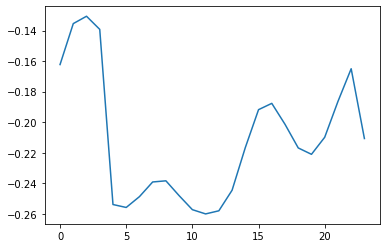

(1, 24, 7)


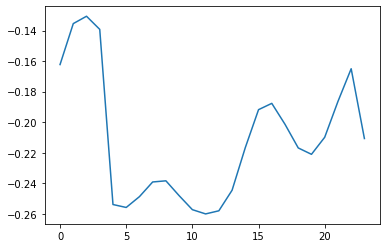

(1, 24, 7)


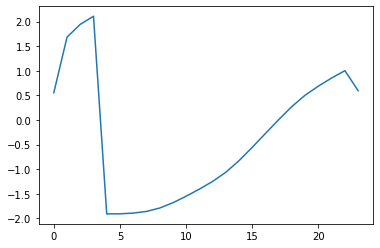

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
#预测OT
plt.plot(prediction[-1,:,-1])#由于prediction.shape是[1,24,7]那么batch只有1 索引只能是0或-1 都是代表batch这一维本身
print(prediction.shape)
plt.show()
plt.plot(prediction[0,:,-1])#没问题
print(prediction.shape)
plt.show()
# draw HUFL prediction
plt.plot(prediction[0,:,0])#没问题
print(prediction.shape)
plt.show()



# try

In [ ]:
exp.train(setting)

In [ ]:
root_path=args.root_path
data_path=args.data_path
print("root_path:", root_path)
print("data_path:", data_path)
print("[args.seq_len, args.label_len, args.pred_len]:", [args.seq_len, args.label_len, args.pred_len])
print("args.features:", args.features)
print("args.target:", args.target)
print("args.freq:", args.freq)

data_set, data_loader = data_provider(args, flag='test')

In [ ]:
data_set
i = 0
print("data_set:", data_set)
for item in data_loader:
  i = i+1
  if i < 5:
    print("item:", item)
    print("item size:", len(item))


